In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import xgboost
from sklearn.model_selection import GroupKFold, KFold
import uuid
import seaborn as sns

In [2]:
train  = pd.read_pickle('Feat5_119_oct_1_feats_train.pkl')
test = pd.read_pickle('Feat5_119_oct_1_feats_test.pkl')

In [3]:
#train.drop(['age_range','marital_status','rented','family_size','no_of_children','income_bracket'], axis = 1, inplace=True)
#test.drop(['age_range','marital_status','rented','family_size','no_of_children','income_bracket'], axis = 1, inplace=True)

In [4]:
# train['duration'] = train['duration'].dt.days
# test['duration'] = test['duration'].dt.days

In [5]:
campaignData = pd.read_csv('campaign_data.csv')
campaignData['start_date'] = pd.to_datetime(campaignData['start_date'], format= '%d/%m/%y')
campaignData['end_date'] = pd.to_datetime(campaignData['end_date'], format= '%d/%m/%y')
campaignData = campaignData.sort_values(by = 'start_date')
testCamp = test.campaign_id.unique()
trainCamp = train.campaign_id.unique()
campaignData['TrainOrTest'] = campaignData['campaign_id'].apply(lambda x : 'Train' if x in trainCamp else 'Test')

In [6]:
train.info(max_cols= 200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 121 columns):
id                               78369 non-null int64
campaign_id                      78369 non-null int64
coupon_id                        78369 non-null int64
customer_id                      78369 non-null int64
redemption_status                78369 non-null int64
item_id_nunique                  78369 non-null int64
item_id_mode                     78369 non-null int64
quantity_mean                    78369 non-null float64
quantity_nunique                 78369 non-null int64
quantity_mode                    78369 non-null int64
quantity_std                     78369 non-null float64
quantity_max_                    78369 non-null int64
selling_price_mean               78369 non-null float64
selling_price_max_               78369 non-null float64
selling_price_min_               78369 non-null float64
selling_price_std                78369 non-null float64
other_discount

In [7]:
target = 'redemption_status'
cat = ['campaign_type', 'brand_type_mode', 'brand_type_category_mode', 'brand_category_mode', 
      'CoupBrandTypeMode', 'age_range', 'marital_status', 'income_bracket', 'family_size']

In [8]:
All = train.append(test)

In [9]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = cat
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))

In [10]:
All, newCols = one_hot_encoder(All, nan_as_category=True)

In [11]:
train = All[~All.redemption_status.isnull()]
test = All[All.redemption_status.isnull()]

In [12]:
toDrop = [x for x in train.columns if train[x].nunique() == 1]

In [13]:
moreToDrop = [x for x in train.columns if x.startswith('Coup')]

In [14]:
notTrainOn = ['id', 'campaign_id']
trainOn = [x for x in train.columns if (x not in notTrainOn ) & (x not in toDrop) & (x!=target) & (x not in moreToDrop)]

In [15]:
gkf = KFold(n_splits=5)

In [16]:
catIndex = [i for i,x in enumerate(trainOn) if x in cat]

In [17]:
oof = np.zeros_like(train[target])
oot = np.zeros_like(test['id']).astype('float')
feature_importance_df = pd.DataFrame()

In [18]:
def getResultSummary(res):
    trainMean = np.mean(list(map(lambda x : x[0], res)))
    validMean = np.mean(list(map(lambda x : x[1], res)))
    trainStd = np.std(list(map(lambda x : x[0], res)))
    validStd = np.std(list(map(lambda x : x[1], res)))
    return {
        
        'Train Mean' : trainMean, 
        'Valid Mean' : validMean, 
        'Train Std'  : trainStd,
        'Valid Std'  : validStd
    }

In [19]:
import lightgbm as lgb

In [20]:
results = []
featureImp = []
i = 0
for train_index, test_index in gkf.split(train[trainOn], train[target]):
    train_X = train.iloc[train_index][trainOn]
    valid_X = train.iloc[test_index][trainOn]
    train_y = train.iloc[train_index][target]
    valid_y = train.iloc[test_index][target]
    dtrain=lgb.Dataset(train_X,label=train_y)
    dvalid=lgb.Dataset(valid_X,label=valid_y)
    params=params={'min_data_in_leaf': 5,
         'num_leaves': 41,
         'learning_rate': 0.026711031423194934,
         'min_child_weight': 0.005238908217059681,
         'colsample_bytree': 0.6044632963222893,
         'bagging_fraction': 0.24901399827744602,
         'min_child_samples': 498.86413570776494,
         'subsample': 0.3650581650899367,
         'reg_lambda': 2.3120762445481233,
         'reg_alpha': 2.7271177752726956,
         'max_depth': 9,
         'scale_pos_weight': 1,
         'objective': 'binary',
         'save_binary': True,
         'seed': 1337,
         'feature_fraction_seed': 1337,
         'bagging_seed': 1337,
         'drop_seed': 1337,
         'data_random_seed': 1337,
         'boosting_type': 'gbdt',
         'verbose': 1,
         'boost_from_average': True,
         'metric': 'auc'}
    model=lgb.train(params,train_set=dtrain,
                valid_sets=[dtrain,dvalid],
                num_boost_round=100000, 
                verbose_eval=1000,
                early_stopping_rounds=100)
    valid_pred = model.predict(valid_X, num_iteration=model.best_iteration)
    train_pred = model.predict(train_X, num_iteration=model.best_iteration)
    
    trainRes = roc_auc_score(train_y, train_pred)
    validRes = roc_auc_score(valid_y, valid_pred)
    
    oof[test_index] = valid_pred
    ootPred = model.predict(test[trainOn], num_iteration=model.best_iteration)
    oot += ootPred / 5
    results.append((trainRes, validRes))
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = trainOn
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    i+=1

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[436]	training's auc: 0.998075	valid_1's auc: 0.963523
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	training's auc: 0.997463	valid_1's auc: 0.941487
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[350]	training's auc: 0.997124	valid_1's auc: 0.957912
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[417]	training's auc: 0.998034	valid_1's auc: 0.959193
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[315]	training's auc: 0.996394	valid_1's auc: 0.963855


In [21]:
getResultSummary(results)

{'Train Mean': 0.9974180186168006,
 'Valid Mean': 0.9571939116981477,
 'Train Std': 0.0006241083265987673,
 'Valid Std': 0.008193342362783528}

In [22]:
results

[(0.9980749346004538, 0.9635231093940044),
 (0.9974633220729646, 0.9414866565354432),
 (0.9971235162679095, 0.9579120912962376),
 (0.9980339517391752, 0.959193060759613),
 (0.9963943684035004, 0.9638546405054405)]

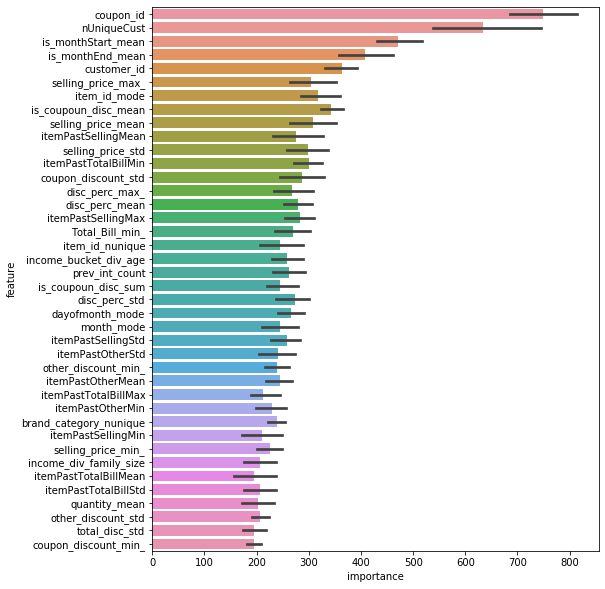

In [23]:
display_importances(feature_importance_df)

In [24]:
def saveStackingFile(prefix):
    oof_ = pd.DataFrame(oof,columns = [prefix])
    oot_ = pd.DataFrame(oot,columns = [prefix])
    print(oof_.shape, oot_.shape)
    oof_.to_csv(prefix + '_train.csv', index = False)
    oot_.to_csv(prefix + '_test.csv', index = False)

saveStackingFile('Feat_5_LGB_Coup_Removed_1337')

(78369, 1) (50226, 1)


In [28]:
test[target] = oot

In [29]:
fileName = str(uuid.uuid4()).split('-')[-1]

In [30]:
test[['id', target]].to_csv(fileName + '.csv', index = False)